# dbitseq

In [2]:
import anndata as ad
import numpy as np
import scanpy as sc
import pandas as pd


import seaborn as sns
from collections import Counter
from sklearn.neighbors import NearestNeighbors
import pandas as pd
import sys
import matplotlib.pyplot as plt
from sklearn.metrics import adjusted_rand_score

from unitednet.interface import UnitedNet
from unitednet.configs import *
from scipy.stats import spearmanr, pearsonr

In [3]:
from sklearn import preprocessing
def change_label(adata,batch):
    adata.obs['batch'] = batch
    adata.obs['imagecol'] = adata.obs['array_col']
    adata.obs['imagerow'] = adata.obs['array_row']
    adata.obs['label'] = adata.obs['cell_type']
    return adata

In [4]:
def pre_ps(adata_list,sc_pre = None):
    adata_list_all = [ad_x.copy() for ad_x in adata_list]
    scalars = []
    assert (adata_list_all[0].X>=0).all(), "poluted input"
    for idx, mod in enumerate(adata_list_all):
        t_x = mod.X
        if sc_pre != None:
            scaler = sc_pre[idx]
        else:
            scaler = preprocessing.StandardScaler().fit(t_x)
        t_x = scaler.transform(t_x)
        mod.X = t_x
        adata_list_all[idx] = mod
        scalars.append(scaler)

    return adata_list_all,scalars

# load dbitseq data

In [5]:
technique = 'dbitseq'
data_path = f"../data/{technique}"
root_save_path = f"../saved_results/{technique}"
device = "cuda:0"

In [6]:
adata_niche_rna_train = sc.read_h5ad(f'{data_path}/adata_niche_rna_train.h5ad')
adata_niche_rna_test = sc.read_h5ad(f'{data_path}/adata_niche_rna_test.h5ad')

adata_rna_train = sc.read_h5ad(f'{data_path}/adata_rna_train.h5ad')
adata_rna_test = sc.read_h5ad(f'{data_path}/adata_rna_test.h5ad')

adata_protein_train = sc.read_h5ad(f'{data_path}/adata_protein_train.h5ad')
adata_protein_test = sc.read_h5ad(f'{data_path}/adata_protein_test.h5ad')


In [7]:
adata_rna_train = change_label(adata_rna_train,'train')
adata_protein_train=change_label(adata_protein_train,'train')
adata_niche_rna_train=change_label(adata_niche_rna_train,'train')

adata_rna_test = change_label(adata_rna_test,'test')
adata_protein_test = change_label(adata_protein_test,'test')
adata_niche_rna_test = change_label(adata_niche_rna_test,'test')

adatas_train = [adata_rna_train, adata_protein_train, adata_niche_rna_train]
adatas_test = [adata_rna_test, adata_protein_test, adata_niche_rna_test]

adatas_all = []
for ad_train, ad_test in zip(adatas_train,adatas_test):
    ad_all = ad_train.concatenate(ad_test,batch_key='sample')
    ad_all = change_label(ad_all,'test')
    adatas_all.append(ad_all)
adatas_all,_ = pre_ps(adatas_all)    
    

adatas_train,_ = pre_ps(adatas_train)   
adatas_test,_ = pre_ps(adatas_test)   


/home/katzalis/thesis/ssh/UnitedNet/.venv/lib/python3.10/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
/home/katzalis/thesis/ssh/UnitedNet/.venv/lib/python3.10/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
/home/katzalis/thesis/ssh/UnitedNet/.venv/lib/python3.10/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32

# Train and finetune UnitedNet

In [8]:
model = UnitedNet(root_save_path, device=device, technique=dbitseq_config)
train_model = False

if train_model:
    model.train(adatas_train,verbose=True)
    model.finetune(adatas_all,verbose=True)
else:
    model.load_model(f"{root_save_path}/train_best.pt",device=device)

# Predict on all data

In [9]:

predict_label = model.predict_label(adatas_all)

print(root_save_path,'ari:',adjusted_rand_score(adatas_all[0].obs['cell_type'],
                    predict_label))

../saved_results/dbitseq ari: 0.17955174352345823


In [10]:
from unitednet.data import create_dataloader
dataloader_test = create_dataloader(
    model.model,
    adatas_train,
    shuffle=False,
    batch_size=model.model.config["train_batch_size"],
)

In [13]:
#smooth and plot results

coord=np.array((list(adatas_all[0].obs['array_row'].astype('int')),
                list(adatas_all[0].obs['array_col'].astype('int')))).T


united_clus=list(predict_label)

coord=np.array((list(adatas_all[0].obs['array_row'].astype('int')),
                list(adatas_all[0].obs['array_col'].astype('int')))).T

nbrs = NearestNeighbors(n_neighbors=5, algorithm='ball_tree').fit(coord)
distances,indices = nbrs.kneighbors(coord)

united_clus_new=[]
for indi,i in enumerate(united_clus):
  np.array(united_clus)[(indices[indi])]
  occurence_count=Counter(np.array(united_clus)[(indices[indi])])
  united_clus_new.append(occurence_count.most_common(1)[0][0])
    

cluster_pl = sns.color_palette('tab20',20)
color_list = [cluster_pl[5],
 cluster_pl[1],
 cluster_pl[2],
 cluster_pl[4],
 cluster_pl[11],
 cluster_pl[6],
 cluster_pl[3],
 cluster_pl[7],
 cluster_pl[8],
 cluster_pl[0],
 cluster_pl[9],]    

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


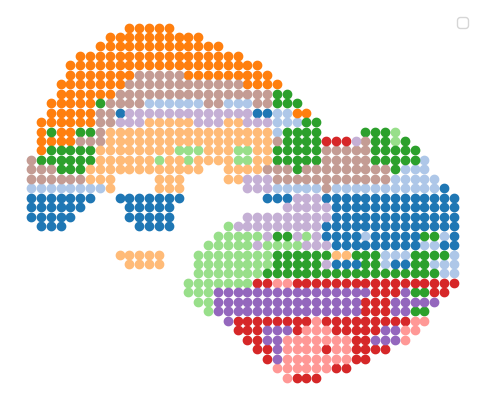

In [14]:
plt.figure(figsize=(6,5))
for idx,clus_id in enumerate(set(united_clus_new)):
    
    plt.scatter(adatas_all[0].obs['array_row'][(united_clus_new==clus_id)],
               adatas_all[0].obs['array_col'][(united_clus_new==clus_id)],
               color=color_list[idx],cmap='tab20')
plt.axis('off')
plt.legend()
